In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report


In [7]:
np.random.seed(42)

df = pd.read_csv("cleaned_rainfall_flood_prediction.csv")

state_counts = df.groupby('SUBDIVISION').size().sort_values(ascending=False)
print("Available states and their data counts:")
print(state_counts.head(10))
print()

# Random state
state = "TAMIL NADU"
df_s = df[df["SUBDIVISION"] == state].sort_values("YEAR").reset_index(drop=True)

print(f"Selected state: {state}")
print(f"Records for {state}: {len(df_s)}")
print(f"Year range: {df_s['YEAR'].min()} to {df_s['YEAR'].max()}")

if len(df_s) < 80:
    print(f"WARNING: {state} has only {len(df_s)} records. Consider using a state with more data:")
    sufficient_states = state_counts[state_counts >= 100].head(5)
    print("States with ≥100 records:")
    for st, count in sufficient_states.items():
        print(f"  - {st}: {count} records")

series_jun = df_s["Jun-Sep"].to_numpy()
series_ann = df_s["ANNUAL"].to_numpy()

# Choose number of lags for Jun-Sep
L = 2  # uses current, t-1, t-2

def z(x):
    """Standardize time series"""
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / x.std()

# Build aligned channels (all same length = len(series_jun) - L)
u_jun_0 = z(series_jun[L:])         # current Jun-Sep
u_ann_0 = z(series_ann[L:])         # current ANNUAL  
u_jun_l1 = z(series_jun[L-1:-1])    # Jun-Sep lag 1
u_jun_l2 = z(series_jun[L-2:-2])    # Jun-Sep lag 2

channels = [u_jun_0, u_ann_0, u_jun_l1, u_jun_l2]
total_len = len(channels[0])
assert all(len(ch) == total_len for ch in channels)

print(f"Multivariate channels created:")
print(f"  - Current Jun-Sep (u_jun_0): length {len(u_jun_0)}")
print(f"  - Current Annual (u_ann_0): length {len(u_ann_0)}")
print(f"  - Jun-Sep lag 1 (u_jun_l1): length {len(u_jun_l1)}")
print(f"  - Jun-Sep lag 2 (u_jun_l2): length {len(u_jun_l2)}")
print(f"  - Total aligned length: {total_len}")

# Labels aligned to the truncated series
flood_threshold = np.percentile(series_jun, 80)  # per-state threshold
flood_labels = (series_jun[L:] > flood_threshold).astype(int)

print(f"Flood threshold (80th percentile for {state}): {flood_threshold:.1f} mm")
print(f"  Low risk (0): {np.sum(flood_labels == 0)} records")
print(f"  High risk (1): {np.sum(flood_labels == 1)} records")

# Time axis for quantum evolution
times = np.arange(total_len)

Available states and their data counts:
SUBDIVISION
WEST UTTAR PRADESH                    115
UTTARAKHAND                           115
TAMIL NADU                            115
SUB HIMALAYAN WEST BENGAL & SIKKIM    115
SOUTH INTERIOR KARNATAKA              115
SAURASHTRA & KUTCH                    115
RAYALSEEMA                            115
PUNJAB                                115
ORISSA                                115
NORTH INTERIOR KARNATAKA              115
dtype: int64

Selected state: TAMIL NADU
Records for TAMIL NADU: 115
Year range: 1901 to 2015
Multivariate channels created:
  - Current Jun-Sep (u_jun_0): length 113
  - Current Annual (u_ann_0): length 113
  - Jun-Sep lag 1 (u_jun_l1): length 113
  - Jun-Sep lag 2 (u_jun_l2): length 113
  - Total aligned length: 113
Flood threshold (80th percentile for TAMIL NADU): 396.9 mm
  Low risk (0): 90 records
  High risk (1): 23 records


In [8]:

num_atoms = 3        # 3 atoms for good feature richness
N_photons = 5        # 5 photon states (balanced performance/speed)
wc = 40.0            # Cavity frequency
wa_list = np.linspace(0, 40, num_atoms)  # Different frequencies for each atom
g = 30.0             # Coupling strength
kappa = 10.0         # Decay rate
epsilon = 20.0       # Input signal strength


def tensor_op(op, j, num_particles, particle_dims):
    op_list = [qt.qeye(dim) for dim in particle_dims]
    op_list[j] = op
    return qt.tensor(op_list)

# Build the quantum system
particle_dims = [N_photons] + [2] * num_atoms
c = tensor_op(qt.destroy(N_photons), 0, num_atoms + 1, particle_dims)
sm_list = [tensor_op(qt.sigmam(), i + 1, num_atoms + 1, particle_dims) for i in range(num_atoms)]
sz_list = [tensor_op(qt.sigmaz(), i + 1, num_atoms + 1, particle_dims) for i in range(num_atoms)]

# The drift Hamiltonian
H0 = wc * c.dag() * c
for i in range(num_atoms):
    H0 += 0.5 * wa_list[i] * sz_list[i]
    H0 += g * (c.dag() * sm_list[i] + c * sm_list[i].dag())

# ============= MULTIPLE DRIVE OPERATORS FOR MULTIVARIATE INPUTS =============
# Define multiple drive operators for richness - one for each input channel
H1_ops = [
    epsilon * 1j * (c - c.dag()),  # cavity quadrature (I) - for u_jun_0
    epsilon * (c + c.dag()),       # cavity quadrature (Q) - for u_ann_0
    epsilon * tensor_op(qt.sigmax(), 1, num_atoms + 1, particle_dims),  # atom 1 - for u_jun_l1
    epsilon * tensor_op(qt.sigmax(), 2, num_atoms + 1, particle_dims),  # atom 2 - for u_jun_l2
]

print(f"Created {len(H1_ops)} drive operators for {len(channels)} input channels")
print(f"Drive operator shapes: {[op.shape for op in H1_ops]}")

# If you have more channels than operators, you can cycle H1_ops
# For now we have exactly 4 operators for 4 channels


scaled_kappa = kappa / (2 * num_atoms + 2)
c_ops = [np.sqrt(scaled_kappa) * c]
for i in range(num_atoms):
    c_ops.append(np.sqrt(scaled_kappa) * sm_list[i])



# ============= MULTIVARIATE HAMILTONIAN CONSTRUCTION =============
# Assemble time-dependent Hamiltonian with multiple drive channels
H = [H0]
for op, coeff in zip(H1_ops, channels):
    H.append([op, coeff])

print(f"Hamiltonian structure:")
print(f"  - H0 (drift): {H0.shape}")
for i, (op, coeff) in enumerate(zip(H1_ops, channels)):
    print(f"  - H1_{i} (channel {i}): {op.shape}, coeff length: {len(coeff)}")

# Split data for training and testing (using total_len from multivariate data)
# Adjust for smaller dataset - BIHAR has only 113 data points
warmup_len = min(30, total_len // 4)  # Reduced warmup for small dataset
remaining_len = total_len - warmup_len
train_len = int(0.6 * remaining_len)  # 60% of remaining for training
test_len = remaining_len - train_len  # Rest for testing

print(f"Data split: Warmup={warmup_len}, Train={train_len}, Test={test_len}")
print(f"Total check: {warmup_len + train_len + test_len} = {total_len}")

# Ensure we have enough data for testing
if test_len <= 0:
    raise ValueError(f"Insufficient data for testing. Total={total_len}, need at least warmup + train + 1")
if test_len < 10:
    print(f"WARNING: Very small test set ({test_len} samples). Consider using a different state with more data.")
print(f"Total check: {warmup_len + train_len + test_len} = {total_len}")

# Ensure we have enough data for testing
if test_len <= 0:
    raise ValueError(f"Insufficient data for testing. Total={total_len}, need at least warmup + train + 1")
if test_len < 10:
    print(f"WARNING: Very small test set ({test_len} samples). Consider using a different state with more data.")

# Initial quantum state
psi0 = qt.tensor([qt.basis(N_photons, 0)] + [qt.basis(2, 0)] * num_atoms)

# Readout operators: cavity and atomic observables
e_ops = [c + c.dag(), 1j * (c.dag() - c)]  # Cavity quadratures
for i in range(num_atoms):
    sx = tensor_op(qt.sigmax(), i + 1, num_atoms + 1, particle_dims)
    sy = tensor_op(qt.sigmay(), i + 1, num_atoms + 1, particle_dims)
    e_ops.extend([sx, sy])

print(f"Evolution setup:")
print(f"  - Time steps: {len(times)}")
print(f"  - Readout operators: {len(e_ops)}")

# Run quantum simulation with multivariate inputs
result = qt.mesolve(H, psi0, times, c_ops, e_ops, options=qt.Options(store_states=True))

Created 4 drive operators for 4 input channels
Drive operator shapes: [(40, 40), (40, 40), (40, 40), (40, 40)]
Hamiltonian structure:
  - H0 (drift): (40, 40)
  - H1_0 (channel 0): (40, 40), coeff length: 113
  - H1_1 (channel 1): (40, 40), coeff length: 113
  - H1_2 (channel 2): (40, 40), coeff length: 113
  - H1_3 (channel 3): (40, 40), coeff length: 113
Data split: Warmup=28, Train=51, Test=34
Total check: 113 = 113
Total check: 113 = 113
Evolution setup:
  - Time steps: 113
  - Readout operators: 8


c:\Users\Priyanshi\anaconda3\envs\qisk\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
c:\Users\Priyanshi\anaconda3\envs\qisk\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [16]:

readouts = np.array(result.expect).T

print(f"Quantum reservoir evolution completed:")
print(f"  - Readout shape: {readouts.shape}")
print(f"  - Time steps: {len(readouts)}")
print(f"  - Observable channels: {readouts.shape[1]}")

# Verify data alignment and adjust if necessary
print(f"\nData alignment verification:")
print(f"  - readouts length: {len(readouts)}")
print(f"  - flood_labels length: {len(flood_labels)}")
print(f"  - warmup_len: {warmup_len}, train_len: {train_len}, test_len: {test_len}")

# Prepare training data using corrected split
X_raw_train = readouts[warmup_len : warmup_len + train_len]
Y_train = flood_labels[warmup_len : warmup_len + train_len]

# Prepare test data
X_raw_test = readouts[warmup_len + train_len : warmup_len + train_len + test_len]
Y_test_actual = flood_labels[warmup_len + train_len : warmup_len + train_len + test_len]

print(f"\nFinal data split:")
print(f"  - X_raw_train shape: {X_raw_train.shape}")
print(f"  - Y_train shape: {Y_train.shape}")
print(f"  - X_raw_test shape: {X_raw_test.shape}")
print(f"  - Y_test_actual shape: {Y_test_actual.shape}")

# Check if we have valid data for both training and testing
if len(X_raw_train) == 0:
    raise ValueError("No training data available. Check data split parameters.")
if len(X_raw_test) == 0:
    raise ValueError("No test data available. Check data split parameters.")

# Create polynomial features for non-linear flood patterns
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_raw_train)
X_poly_test = poly.transform(X_raw_test)


from sklearn.linear_model import Ridge


print(f"  - Polynomial features train: {X_poly_train.shape}")
print(f"  - Polynomial features test: {X_poly_test.shape}")

# Check for feature dimension consistency
if X_poly_train.shape[1] != X_poly_test.shape[1]:
    raise ValueError(f"Feature dimension mismatch: train={X_poly_train.shape[1]}, test={X_poly_test.shape[1]}")

# Train Ridge model (no manual bias needed - Ridge handles intercept automatically)
model = Ridge(alpha=1.0, fit_intercept=True)
model.fit(X_poly_train, Y_train)


print(f"  - Alpha (regularization): {model.alpha}")
print(f"  - Intercept: {model.intercept_:.4f}")
print(f"  - Coefficients shape: {model.coef_.shape}")
print(f"  - Coefficient L2 norm: {np.linalg.norm(model.coef_):.4f}")
print(f"  - Training R² score: {model.score(X_poly_train, Y_train):.4f}")

# Make predictions
Y_predicted_raw = model.predict(X_poly_test)
Y_predicted = (Y_predicted_raw > 0.5).astype(int)

print(f"  - Raw prediction range: [{Y_predicted_raw.min():.3f}, {Y_predicted_raw.max():.3f}]")
print(f"  - Predicted classes: {np.bincount(Y_predicted)} (0s, 1s)")

Quantum reservoir evolution completed:
  - Readout shape: (113, 8)
  - Time steps: 113
  - Observable channels: 8

Data alignment verification:
  - readouts length: 113
  - flood_labels length: 113
  - warmup_len: 28, train_len: 51, test_len: 34

Final data split:
  - X_raw_train shape: (51, 8)
  - Y_train shape: (51,)
  - X_raw_test shape: (34, 8)
  - Y_test_actual shape: (34,)
  - Polynomial features train: (51, 44)
  - Polynomial features test: (34, 44)
  - Alpha (regularization): 1.0
  - Intercept: -0.0593
  - Coefficients shape: (44,)
  - Coefficient L2 norm: 0.5262
  - Training R² score: 0.8046
  - Raw prediction range: [-0.120, 1.365]
  - Predicted classes: [27  7] (0s, 1s)


In [11]:

from sklearn.linear_model import Ridge

# Use polynomial features (without manual bias since Ridge handles intercept)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_raw_train)
X_poly_test = poly.transform(X_raw_test)

# Train Ridge model (alpha=1.0 for moderate regularization)
model = Ridge(alpha=1.0, fit_intercept=True)
model.fit(X_poly_train, Y_train)


print(f"  - Training samples: {X_poly_train.shape[0]}")
print(f"  - Polynomial features: {X_poly_train.shape[1]}")
print(f"  - Alpha (regularization): {model.alpha}")
print(f"  - Intercept: {model.intercept_:.4f}")
print(f"  - Coefficient L2 norm: {np.linalg.norm(model.coef_):.4f}")
print(f"  - Training R² score: {model.score(X_poly_train, Y_train):.4f}")

# Make predictions
Y_predicted_raw = model.predict(X_poly_test)
Y_predicted = (Y_predicted_raw > 0.5).astype(int)

print(f"\nPrediction stats:")
print(f"  - Raw prediction range: [{Y_predicted_raw.min():.3f}, {Y_predicted_raw.max():.3f}]")
print(f"  - Predicted classes: {np.bincount(Y_predicted)} (0s, 1s)")


  - Training samples: 51
  - Polynomial features: 44
  - Alpha (regularization): 1.0
  - Intercept: -0.0593
  - Coefficient L2 norm: 0.5262
  - Training R² score: 0.8046

Prediction stats:
  - Raw prediction range: [-0.120, 1.365]
  - Predicted classes: [27  7] (0s, 1s)


In [17]:
# Make predictions
Y_predicted_raw = X_test @ W
Y_predicted = (Y_predicted_raw > 0.5).astype(int)  # Convert to binary

# Calculate metrics
mse = mean_squared_error(Y_test_actual, Y_predicted_raw)
accuracy = np.mean(Y_predicted == Y_test_actual)


print(f"State: {state}")
print(f"Input channels: Current Jun-Sep, Current Annual, Jun-Sep lag-1, Jun-Sep lag-2")
print(f"Drive operators: {len(H1_ops)} (cavity I/Q, atom 1/2 sigmax)")
print()
print(f"Performance Metrics:")
print(f"  MSE: {mse:.4f}")
print(f"  Accuracy: {accuracy:.3f}")
print()

print(classification_report(Y_test_actual, Y_predicted, 
                          target_names=['Low Flood Risk', 'High Flood Risk']))

State: TAMIL NADU
Input channels: Current Jun-Sep, Current Annual, Jun-Sep lag-1, Jun-Sep lag-2
Drive operators: 4 (cavity I/Q, atom 1/2 sigmax)

Performance Metrics:
  MSE: 1.9345
  Accuracy: 0.794

                 precision    recall  f1-score   support

 Low Flood Risk       0.91      0.81      0.86        26
High Flood Risk       0.55      0.75      0.63         8

       accuracy                           0.79        34
      macro avg       0.73      0.78      0.74        34
   weighted avg       0.83      0.79      0.80        34



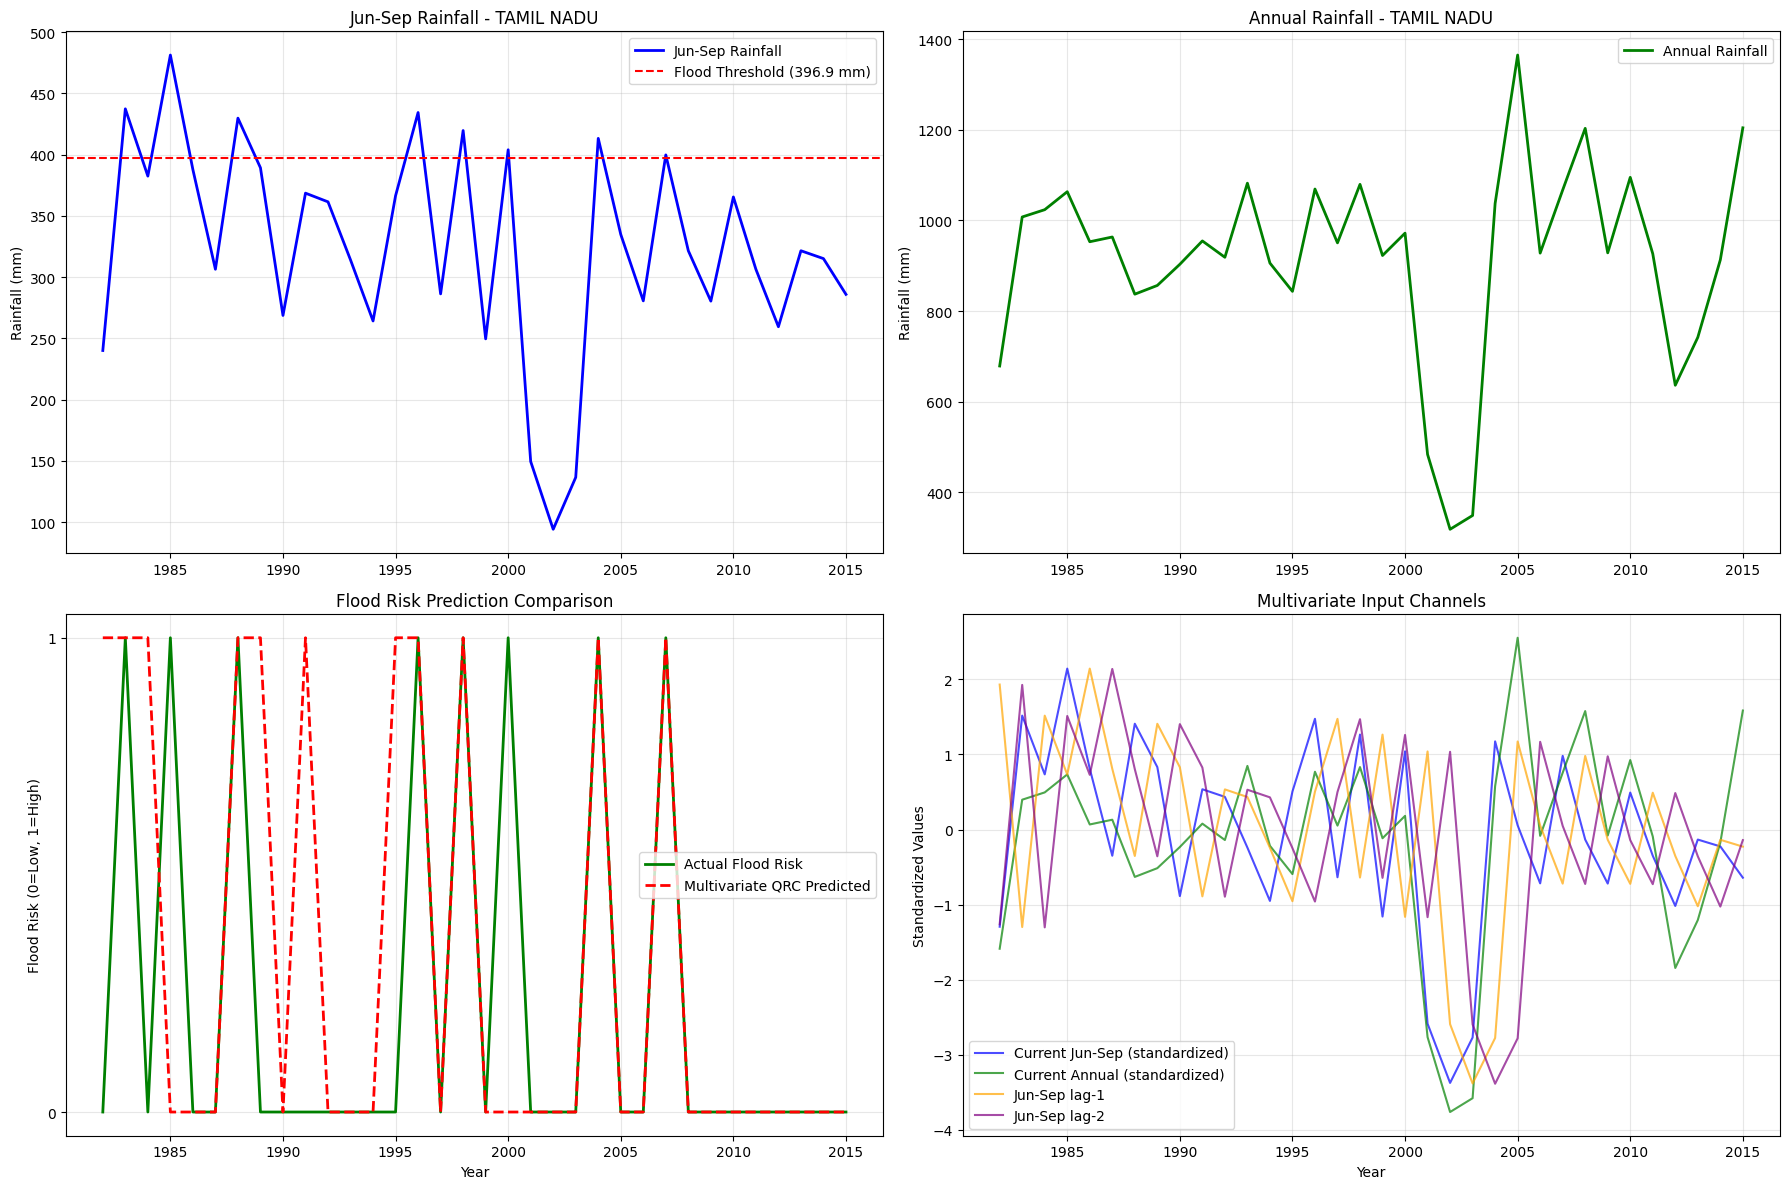

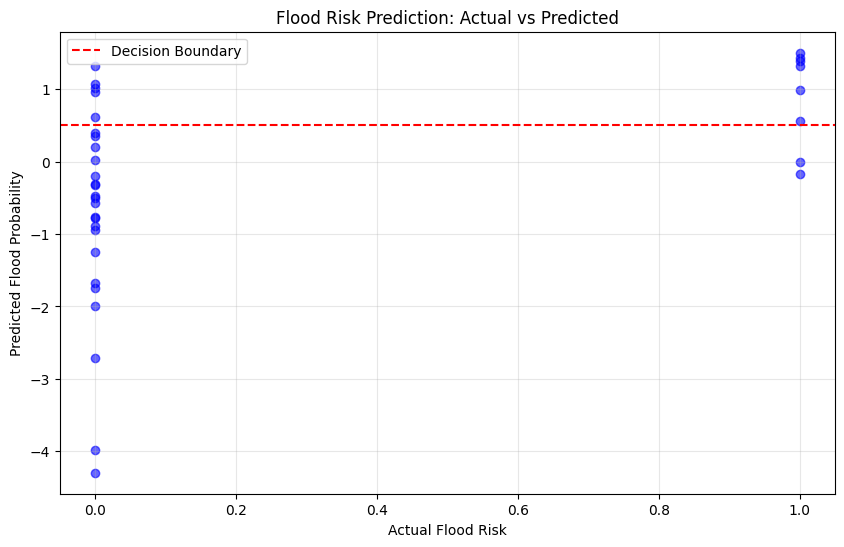

In [18]:


# Plot 1: Multivariate channels and flood risk over time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Get the test indices for the aligned data
test_start_idx = warmup_len + train_len
test_end_idx = warmup_len + train_len + test_len
test_years = df_s['YEAR'].iloc[L + test_start_idx:L + test_end_idx].values

# Plot Jun-Sep rainfall (current and with threshold)
test_jun_data = series_jun[L + test_start_idx:L + test_end_idx]
ax1.plot(test_years, test_jun_data, 'b-', label='Jun-Sep Rainfall', linewidth=2)
ax1.axhline(y=flood_threshold, color='r', linestyle='--', label=f'Flood Threshold ({flood_threshold:.1f} mm)')
ax1.set_ylabel('Rainfall (mm)')
ax1.set_title(f'Jun-Sep Rainfall - {state}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Annual rainfall
test_ann_data = series_ann[L + test_start_idx:L + test_end_idx]
ax2.plot(test_years, test_ann_data, 'g-', label='Annual Rainfall', linewidth=2)
ax2.set_ylabel('Rainfall (mm)')
ax2.set_title(f'Annual Rainfall - {state}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot flood predictions
ax3.plot(test_years, Y_test_actual, 'g-', label='Actual Flood Risk', linewidth=2)
ax3.plot(test_years, Y_predicted, 'r--', label='Multivariate QRC Predicted', linewidth=2)
ax3.set_ylabel('Flood Risk (0=Low, 1=High)')
ax3.set_xlabel('Year')
ax3.set_title('Flood Risk Prediction Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yticks([0, 1])

# Plot input channels (standardized)
test_range = slice(test_start_idx, test_end_idx)
ax4.plot(test_years, u_jun_0[test_range], 'b-', label='Current Jun-Sep (standardized)', alpha=0.7)
ax4.plot(test_years, u_ann_0[test_range], 'g-', label='Current Annual (standardized)', alpha=0.7)
ax4.plot(test_years, u_jun_l1[test_range], 'orange', label='Jun-Sep lag-1', alpha=0.7)
ax4.plot(test_years, u_jun_l2[test_range], 'purple', label='Jun-Sep lag-2', alpha=0.7)
ax4.set_ylabel('Standardized Values')
ax4.set_xlabel('Year')
ax4.set_title('Multivariate Input Channels')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Prediction vs Actual scatter
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_actual, Y_predicted_raw, alpha=0.6, c='blue')
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Boundary')
plt.xlabel('Actual Flood Risk')
plt.ylabel('Predicted Flood Probability')
plt.title('Flood Risk Prediction: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
